In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
import time

%matplotlib inline

# #!pip install ipympl
# %matplotlib widget
import sys
import os
sys.path.append(os.path.abspath("../external"))
sys.path.append(os.path.abspath("../external/causal_comp"))
sys.path.append(os.path.abspath("../external/tigramite"))

seed = 42
np.random.seed(seed)

# 2D model

## LKIFR

In [2]:
from causal_comp.function_liang_nvar import compute_sig
from causal_comp.function_liang_nvar import compute_liang_nvar

In [3]:
# Time series
load_series = True # True: load time series; False: compute and save time series
# save_var = True # True: save Liang index and correlation coefficient (for plotting afterwards); False: don't save variables

filename = '../data/2D_series.npy'
var_filename = '../results/npy/2D_liang.npy'
if load_series == True: # load time series
    t, X1, X2 = np.load(filename, allow_pickle=True)
    T, tau, R, error_T, error_tau, error_R, sig_T, sig_tau, sig_R = np.load(var_filename, allow_pickle=True)

In [4]:
# Time Parameters and Simulation Settings
dt = 0.001
tmax = 1000 # takes around 9 mins
nt = int(tmax / dt)
t = np.linspace(0, tmax, nt)
start_computation = int(10 / dt)  # discard transients
n_iter = 200 # bootstrap samples for Liang
nvar = 2

In [5]:
if load_series==False:
    # Simulate 2D Time Series
    a11, a12 = -1, 0.5
    a21, a22 = 0, -1
    sigma1, sigma2 = 0.1, 0.1
    dW1 = np.sqrt(dt) * np.random.normal(0, 1, nt)
    dW2 = np.sqrt(dt) * np.random.normal(0, 1, nt)
    X1, X2 = np.zeros(nt), np.zeros(nt)
    X1[0], X2[0] = 1.0, 2.0
    
    for i in range(nt - 1):
        X1[i + 1] = X1[i] + (a11 * X1[i] + a12 * X2[i]) * dt + sigma1 * dW1[i]
        X2[i + 1] = X2[i] + (a22 * X2[i] + a21 * X1[i]) * dt + sigma2 * dW2[i]
    
    # Apply Liang-Kleeman Info Flow on Post-Transient Segment
    print("Computing the Information Flow Rate...")
    start_L2 = time.time()
    xx = np.array([X1[start_computation:], X2[start_computation:]])
    T, tau, R, error_T, error_tau, error_R = compute_liang_nvar(xx, dt, n_iter)
    print(f"LKIFR computation time: {time.time() - start_L2:.2f} seconds")

In [6]:
# # Significance Check
# alpha_level = 0.05   # controling false positives
# conf = norm.ppf(1 - alpha_level / 2)
# sig_T = np.zeros((nvar, nvar))
# sig_tau = np.zeros((nvar, nvar))
# sig_R = np.zeros((nvar, nvar))

# for j in range(nvar):
#     for k in range(nvar):
#         sig_T[j, k] = compute_sig(T[j, k], error_T[j, k], conf)
#         sig_tau[j, k] = compute_sig(tau[j, k], error_tau[j, k], conf)
#         sig_R[j, k] = compute_sig(R[j, k], error_R[j, k], conf)

# Results
print("\nLiang-Kleeman Info Transfer (T):")
print(T)
print("\nNormalized Info Transfer (% tau):")
print(tau)
print("\nPearson Correlation (R):")
print(R)

print("\nSignificance of T (1=significant):")
print(sig_T)
print("\nSignificance of tau:")
print(sig_tau)
print("\nSignificance of R:")
print(sig_R)


Liang-Kleeman Info Transfer (T):
[[-0.97944602  0.00578939]
 [ 0.10135035 -1.0512221 ]]

Normalized Info Transfer (% tau):
[[-49.96531961   0.27532049]
 [  5.17027232 -49.9919793 ]]

Pearson Correlation (R):
[[1.         0.22942272]
 [0.22942272 1.        ]]

Significance of T (1=significant):
[[1. 0.]
 [1. 1.]]

Significance of tau:
[[1. 0.]
 [1. 1.]]

Significance of R:
[[1. 1.]
 [1. 1.]]


In [7]:
if load_series==False:
    # Save time series and results
    np.save('../data/2D_series_new.npy', [t, X1, X2])
    np.save('../results/npy/2D_liang_new.npy', [T, tau, R, error_T, error_tau, error_R, sig_T, sig_tau, sig_R])

## PCMCI

In [8]:
from tigramite.data_processing import DataFrame
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.pcmci import PCMCI

Tigramite takes input data as 2D Numpy array of shape (T:num of timesteps, N:num of variables)
Our simulated series X1, X2 are shaped (nt,) that is, each is a separate 1D timeseries. So, 
we will make the array (2, T) and then we\ll transpose it to be ready for Tigramite's DataFrame class.

In [10]:
data_raw = np.array([X1[start_computation:], X2[start_computation:]]).T  # shape: (T, 2)
dataframe = DataFrame(data_raw, var_names=["X1", "X2"])

# Set up ParCorr test and PCMCI object
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr)
alpha_level = 0.05
tau_max = 3

# Run PCMCI (includes graph output by thresholding p_matrix)
results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=alpha_level)

# FDR-corrected p-values
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')

# Retrieve inferred parents from graph
parents_dict = pcmci.return_parents_dict(graph=results['graph'], val_matrix=results['val_matrix'])

# # Show beta matrix at lag 1
# print("\nPCMCI Path Coefficients (val_matrix) at lag=1:")
# print(results['val_matrix'][:, :, 1])

# print("\nInferred parents per variable (from graph):")
# print(parents_dict)

# print("\nFDR-corrected for significant p-values in q-matrix:")
# print(significant)

# Printing results ##########
print(f'Note: Alpha level {alpha_level} means accepting a {alpha_level*100:.1f}% chance of falsely detecting a link that is not true.')
pcmci.print_significant_links(p_matrix = q_matrix, val_matrix = results['val_matrix'], alpha_level = alpha_level)
graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=alpha_level, tau_min=0, tau_max=tau_max, link_assumptions=None)
results['graph'] = graph

# Retrieving inferred parents from above (corrected) graph
parents_dict = pcmci.return_parents_dict(graph=results['graph'], val_matrix=results['val_matrix'])

# Show beta (path coefficients) matrix at lag 1
print("\nPCMCI Path Coefficients (val_matrix) at lag=1:")
print(' ', results['val_matrix'][:, :, 1])

print("\nInferred parents per variable (from graph):")
for var, parents in parents_dict.items():
    varname = dataframe.var_names[var]
    formatted = ', '.join(f"{dataframe.var_names[pv]}(t{lag})" for pv, lag in parents)
    print(f"  {varname}(t) ← {formatted}")



Note: Alpha level 0.05 means accepting a 5.0% chance of falsely detecting a link that is not true.

## Significant links at alpha = 0.05:

    Variable X1 has 1 link(s):
        (X1 -1): pval = 0.00000 | val =  0.707

    Variable X2 has 1 link(s):
        (X2 -1): pval = 0.00000 | val =  0.706

PCMCI Path Coefficients (val_matrix) at lag=1:
  [[0.70656187 0.00194443]
 [0.00071363 0.7062371 ]]

Inferred parents per variable (from graph):
  X1(t) ← X1(t-1)
  X2(t) ← X2(t-1)


# 6D model

## LKIFR

In [11]:
from causal_comp.function_liang_nvar import compute_liang_nvar, compute_sig

In [12]:
# Options
load_series = True # True: load already saved time series (x,y,z); False: compute and save time series
save_var = False # True: save Liang index and correlation coefficient (for plotting afterwards); False: don't save variables

filename = '../data/6D_series.npy'
var_filename = '../results/npy/6D_liang.npy'
if load_series == True: # load time series
    t, X1, X2, X3, X4, X5, X6 = np.load(filename,allow_pickle=True)
    T, tau, R, error_T, error_tau, error_R, sig_T, sig_tau, sig_R = np.load(var_filename, allow_pickle=True)    

In [13]:
nvar_6d = 6 # number of variables (Liang [2021]: nvar=6)
n_iter = 400 # nuof bootstrap realizations (for computing the error in Liang index)
b_factor = 1 # amplitude of stochastic perturbation
conf = 1.96 # 1.96 if 95% confidence interval; 2.58 if 99% confidence interval; 1.65 if 90% confidence interval

# Time parameters
dt = 1 # time step
tmax = 1.e6 # total duration in unit times
nt = int(tmax / dt) # number of time steps (Liang [2021]: nt=10000)
t = np.linspace(0,tmax,nt) # time vector (varying between 0 and tmax with nt time steps)
start_computation = int(10000 / dt) # exclude the first transient times for computing correlation coefficient and rate of information transfer

In [14]:
if load_series==False:
    # Simulate 6D Time Series
    alpha = np.array([0.1,0.7,0.5,0.2,0.8,0.3])
    A = np.array([(0, 0, -0.6, 0, 0, 0),
    			  (-0.5, 0, 0, 0, 0, 0.8),
    			  (0, 0.7, 0, 0, 0, 0),
    			  (0, 0, 0, 0.7, 0.4, 0),
    			  (0, 0, 0, 0.2, 0, 0.7),
    			  (0, 0, 0, 0, 0, -0.5)])
    B = np.ones(nvar) * b_factor

    # Random errors
    mean_e = 0
    std_e = 1
    e = np.zeros((nvar,nt))
    for var in np.arange(nvar):
        e[var,:] = np.random.normal(mean_e,std_e,nt)
    
    # Initialization of variables
    X = np.zeros((nvar,nt))
    T = np.zeros((nvar,nvar))
    tau = np.zeros((nvar,nvar))
    R = np.zeros((nvar,nvar))
    error_T = np.zeros((nvar,nvar))
    error_tau = np.zeros((nvar,nvar))
    error_R = np.zeros((nvar,nvar))

    # VAR model
    for i in np.arange(nt-1):
        for var in np.arange(nvar):
            X[var,i+1] = alpha[var] + np.sum(A[var,:] * X[:,i]) + B[var] * e[var,i+1]

    # Apply Liang-Kleeman Info Flow on Post-Transient Segment
    print("Computing the Information Flow Rate...")
    start_L6 = time.time()
    xx = np.array((X[0,start_computation::],
                   X[1,start_computation::],
                   X[2,start_computation::],
                   X[3,start_computation::],
                   X[4,start_computation::],
                   X[5,start_computation::]))
    T, tau, R, error_T, error_tau, error_R = compute_liang_nvar(xx, dt, n_iter)
    print(f"LKIFR computation time for 6D system: {time.time() - start_L6:.2f} seconds")
else:
    print(f'Significance testing on {var_filename}...')

Significance testing on ../results/npy/6D_liang.npy...


Compute significance of rate of information transfer and correlation coefficient (by combining bootstrap samples)


In [15]:
# # Significance Check
# conf = 1.96  # for 95% confidence
# sig_T = np.zeros((nvar,nvar))
# sig_tau = np.zeros((nvar,nvar))
# sig_R = np.zeros((nvar,nvar))

# for j in np.arange(nvar):
#     for k in np.arange(nvar):
#         sig_T[j,k] = compute_sig(T[j,k],error_T[j,k],conf)
#         sig_tau[j,k] = compute_sig(tau[j,k],error_tau[j,k],conf)
#         sig_R[j,k] = compute_sig(R[j,k],error_R[j,k],conf)

# Results
print("\nLiang-Kleeman Info Transfer (T) [6D]:")
print(T)
print("\nNormalized Info Transfer (% tau) [6D]:")
print(tau)
print("\nPearson Correlation (R) [6D]:")
print(R)

print("\nSignificance of T [6D]:")
print(sig_T)
print("\nSignificance of tau [6D]:")
print(sig_tau)
print("\nSignificance of R [6D]:")
print(sig_R)



Liang-Kleeman Info Transfer (T) [6D]:
[[-9.99813539e-01  1.22778826e-02  9.45702946e-06 -1.99191622e-07
   1.47526177e-05  2.13753791e-05]
 [-1.21380506e-06 -1.00221419e+00 -9.15105787e-02 -1.20269742e-05
   5.23070109e-04 -7.74923041e-05]
 [-3.88334326e-02 -6.16887429e-05 -9.99346085e-01 -3.59360638e-05
   7.44331306e-05 -1.05505787e-04]
 [-9.43335953e-08  2.71796218e-05  3.12757633e-05 -2.99194938e-01
   3.70673050e-02 -3.99155694e-05]
 [-4.70135792e-05  3.91032358e-04  2.54368927e-04  4.57433271e-02
  -1.00229140e+00  1.67191010e-05]
 [-2.82393700e-05 -1.84482243e-01 -7.70080075e-05 -1.70598690e-05
  -1.85379191e-01 -1.49975035e+00]]

Normalized Info Transfer (% tau) [6D]:
[[-7.55675946e+01  8.62996499e-01  7.11341667e-04 -3.84588206e-05
   9.80053335e-04  1.13999479e-03]
 [-9.17414346e-05 -7.04443398e+01 -6.88327006e+00 -2.32210189e-03
   3.47488572e-02 -4.13283072e-03]
 [-2.93509638e+00 -4.33602200e-03 -7.51691124e+01 -6.93833713e-03
   4.94477926e-03 -5.62684981e-03]
 [-7.129892

In [16]:
if load_series==False:
    # Save time series and results
    np.save('../data/6D_series_new.npy',[t, X1, X2, X3, X4, X5, X6])
    np.save('../results/npy/6D_liang_new.npy',[T,tau,R,error_T,error_tau,error_R,sig_T,sig_tau,sig_R])


## PCMCI

In [23]:
data_6d_cut = np.array([X1[start_computation:], X2[start_computation:], X3[start_computation:], 
                        X4[start_computation:], X5[start_computation:], X6[start_computation:]]).T  # shape: (T, 6)

dataframe_6d = DataFrame(data_6d_cut, var_names=[f"X{i+1}" for i in range(nvar_6d)])

# Run PCMCI
parcorr = ParCorr(significance='analytic')
alpha_level = 0.05
tau_max = 3
pcmci_6d = PCMCI(dataframe=dataframe_6d, cond_ind_test=parcorr)
results_6d = pcmci_6d.run_pcmci(tau_max=tau_max, pc_alpha=alpha_level)

# FDR-corrected p-values
q_matrix_6d = pcmci_6d.get_corrected_pvalues(p_matrix=results_6d['p_matrix'], fdr_method='fdr_bh')
significant_6d = q_matrix_6d < alpha_level

# Inferred parents
parents_dict_6d = pcmci_6d.return_parents_dict(graph=results_6d['graph'], val_matrix=results_6d['val_matrix'])

# Printing results_6d ##########
print(f'Note: Alpha level {alpha_level} means accepting a {alpha_level*100:.1f}% chance of falsely detecting a link that is not true.')
pcmci_6d.print_significant_links(p_matrix = q_matrix_6d, val_matrix = results_6d['val_matrix'], alpha_level = alpha_level)
graph = pcmci_6d.get_graph_from_pmatrix(p_matrix=q_matrix_6d, alpha_level=alpha_level, tau_min=0, tau_max=tau_max, link_assumptions=None)
results_6d['graph'] = graph

# Retrieving inferred parents from above (corrected) graph
parents_dict_6d = pcmci_6d.return_parents_dict(graph=results_6d['graph'], val_matrix=results_6d['val_matrix'])

# Show beta (path coefficients) matrix at lag 1
print("\nPCMCI Path Coefficients (val_matrix) at lag=1:")
print(' ', results_6d['val_matrix'][:, :, 1])

print("\nInferred parents per variable (from graph):")
for var, parents in parents_dict_6d.items():
    varname = dataframe_6d.var_names[var]
    formatted = ', '.join(f"{dataframe_6d.var_names[pv]}(t{lag})" for pv, lag in parents)
    print(f"  {varname}(t) ← {formatted}")

Note: Alpha level 0.05 means accepting a 5.0% chance of falsely detecting a link that is not true.

## Significant links at alpha = 0.05:

    Variable X1 has 1 link(s):
        (X3 -1): pval = 0.00000 | val = -0.515

    Variable X2 has 2 link(s):
        (X6 -1): pval = 0.00000 | val =  0.624
        (X1 -1): pval = 0.00000 | val = -0.446

    Variable X3 has 1 link(s):
        (X2 -1): pval = 0.00000 | val =  0.574

    Variable X4 has 2 link(s):
        (X4 -1): pval = 0.00000 | val =  0.573
        (X5 -1): pval = 0.00000 | val =  0.370

    Variable X5 has 2 link(s):
        (X6 -1): pval = 0.00000 | val =  0.573
        (X4 -1): pval = 0.00000 | val =  0.196

    Variable X6 has 1 link(s):
        (X6 -1): pval = 0.00000 | val = -0.447

PCMCI Path Coefficients (val_matrix) at lag=1:
  [[ 8.48694301e-04 -4.46229470e-01 -5.28553795e-04  1.97383506e-04
   5.08949336e-05  1.13028479e-03]
 [ 4.09408318e-04 -2.51196331e-03  5.73575503e-01 -7.01450196e-04
   2.25518029e-03  8.68378565e

##### Draft Plotting 

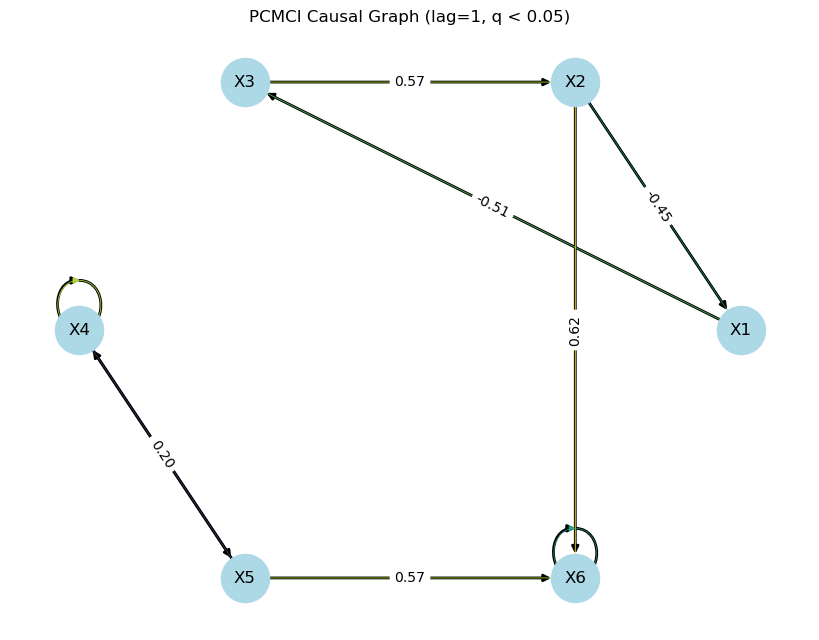

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Given: val_matrix and significant mask
val_matrix = results_6d['val_matrix'][:, :, 1]  # Only lag=1
sig_links = significant_6d[:, :, 1]
var_names = [f"X{i+1}" for i in range(val_matrix.shape[0])]

# 1. Heatmap of path coefficients
plt.figure(figsize=(8, 6))
sns.heatmap(val_matrix, xticklabels=var_names, yticklabels=var_names, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("PCMCI Path Coefficients (lag=1)")
plt.xlabel("Cause")
plt.ylabel("Effect")
plt.tight_layout()
plt.savefig("../results/plots/pcmci_6d_val_matrix_lag1.png")
plt.close()

# 2. Binary heatmap of significant links
plt.figure(figsize=(8, 6))
sns.heatmap(sig_links, xticklabels=var_names, yticklabels=var_names, cmap="Blues", cbar=False, annot=True)
plt.title("Significant Links (q < 0.05, lag=1)")
plt.xlabel("Cause")
plt.ylabel("Effect")
plt.tight_layout()
plt.savefig("../results/plots/pcmci_6d_significant_links_lag1.png")
plt.close()

# 3. Network graph of significant causal links
G = nx.DiGraph()
G.add_nodes_from(var_names)

for i in range(val_matrix.shape[0]):
    for j in range(val_matrix.shape[1]):
        if sig_links[i, j]:
            G.add_edge(var_names[j], var_names[i], weight=val_matrix[i, j])  # edge: cause -> effect

plt.figure(figsize=(8, 6))
pos = nx.circular_layout(G)
edges = G.edges(data=True)
weights = [abs(d['weight']) for (_, _, d) in edges]

nx.draw(G, pos, with_labels=True, node_size=1200, node_color="lightblue", arrows=True, width=2)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, edge_color=weights, edge_cmap=plt.cm.viridis)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("PCMCI Causal Graph (lag=1, q < 0.05)")
# plt.tight_layout()
plt.savefig("../results/plots/pcmci_6d_network_graph_lag1.png")
# plt.close()


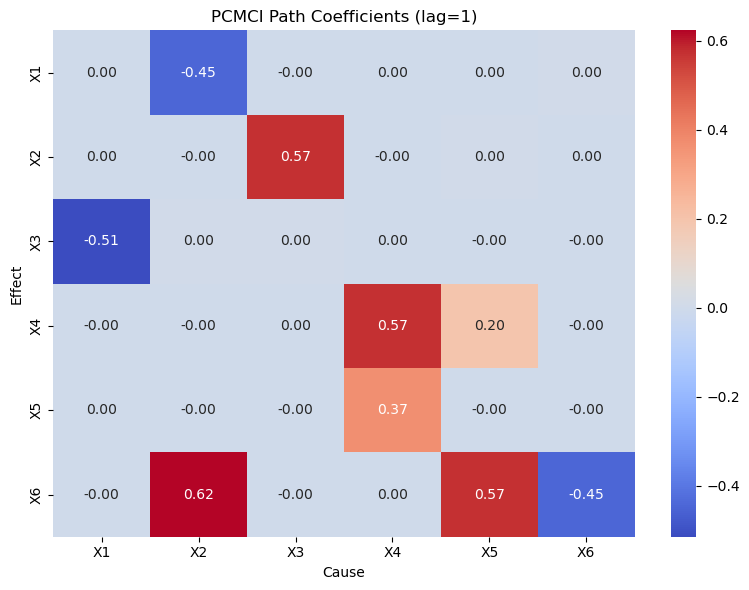

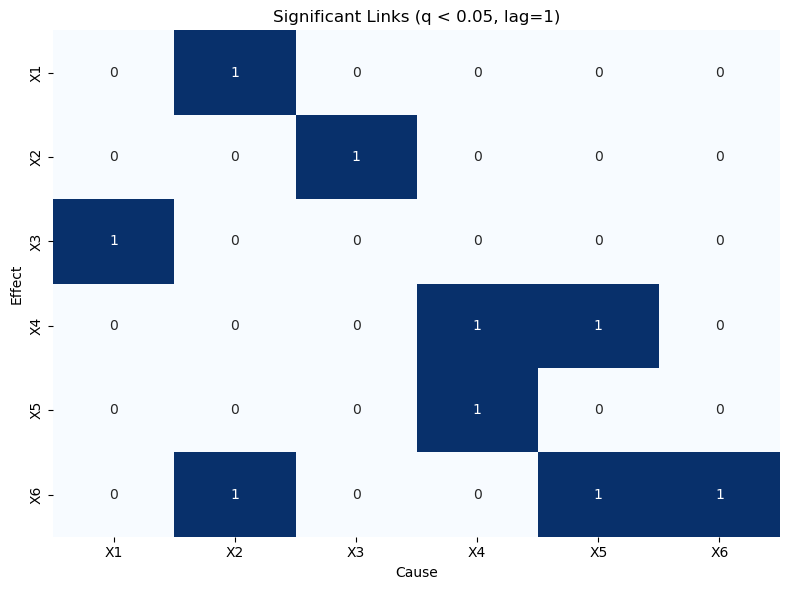

C:\Users\camen\AppData\Local\Temp\ipykernel_24880\709798589.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


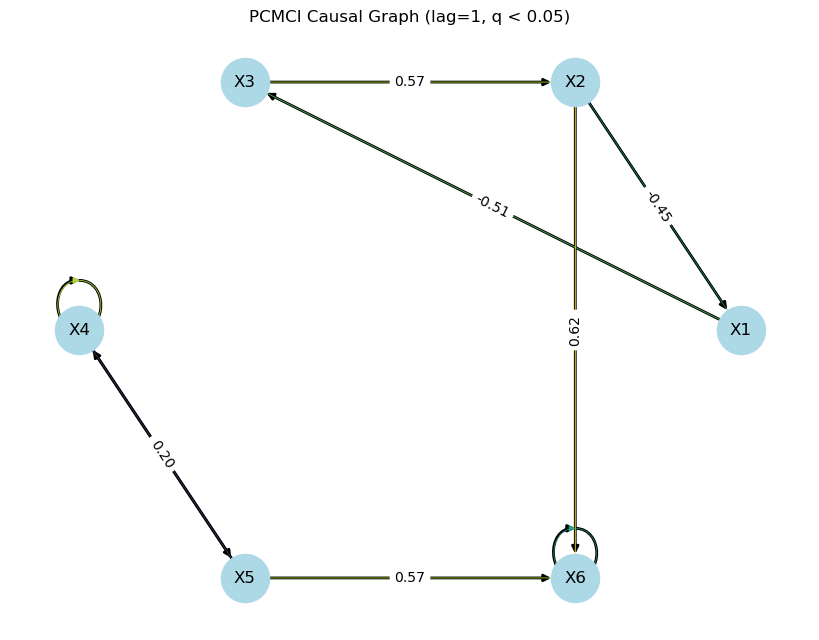

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

# Create results folder if not exist
os.makedirs("../results/plots", exist_ok=True)

# --- Variables ---
val_matrix = results_6d['val_matrix'][:, :, 1]  # Only lag=1
sig_links = significant_6d[:, :, 1]
var_names = [f"X{i+1}" for i in range(val_matrix.shape[0])]

# --- 1. Heatmap of path coefficients ---
plt.figure(figsize=(8, 6))
sns.heatmap(val_matrix, xticklabels=var_names, yticklabels=var_names, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("PCMCI Path Coefficients (lag=1)")
plt.xlabel("Cause")
plt.ylabel("Effect")
plt.tight_layout()
plt.savefig("../results/plots/pcmci_6d_val_matrix_lag1.png")
plt.show()

# --- 2. Binary heatmap of significant links ---
plt.figure(figsize=(8, 6))
sns.heatmap(sig_links, xticklabels=var_names, yticklabels=var_names, cmap="Blues", cbar=False, annot=True)
plt.title("Significant Links (q < 0.05, lag=1)")
plt.xlabel("Cause")
plt.ylabel("Effect")
plt.tight_layout()
plt.savefig("../results/plots/pcmci_6d_significant_links_lag1.png")
plt.show()

# --- 3. Network graph of significant causal links ---
G = nx.DiGraph()
G.add_nodes_from(var_names)

for i in range(val_matrix.shape[0]):
    for j in range(val_matrix.shape[1]):
        if sig_links[i, j]:
            G.add_edge(var_names[j], var_names[i], weight=val_matrix[i, j])  # cause -> effect

plt.figure(figsize=(8, 6))
pos = nx.circular_layout(G)
edges = G.edges(data=True)
weights = [abs(d['weight']) for (_, _, d) in edges]

nx.draw(G, pos, with_labels=True, node_size=1200, node_color="lightblue", arrows=True, width=2)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, edge_color=weights, edge_cmap=plt.cm.viridis)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("PCMCI Causal Graph (lag=1, q < 0.05)")
plt.tight_layout()
plt.savefig("../results/plots/pcmci_6d_network_graph_lag1.png")
plt.show()


# Real Data

## LKIFR

In [44]:
from causal_comp.function_liang_nvar import compute_sig
from causal_comp.function_liang_nvar import compute_liang_nvar

### CO2 NOAA-deseasoned, Temp plain average

The attempt below uses the deseasonalized CO2 data from Mauna Loa, preprocessed by NOAA. It's deseasoning process uses a digial filter and the seasonal component is estimated using a nontlinear iterative curve fitting method (Thoning et al. 1989). The temperature dataset uses monthly mean, firstly without de-seasonining.

In [45]:
df = pd.read_pickle("../data/temp_co2_aligned.pkl")
df

,temperature,co2
1958-03-01,5.110323,314.44
1958-04-01,8.125792,315.16
1958-05-01,11.181393,314.69
1958-06-01,12.985923,315.15
1958-07-01,14.422375,315.20
...,...,...
2025-01-01,4.449924,426.35
2025-02-01,4.444533,426.15
2025-03-01,6.837699,426.69
2025-04-01,9.779043,427.13


In [53]:
temp = df.iloc[:,0].values
co2 = df.iloc[:,1].values
dt = 1/12
n_iter=200
xx = np.array([temp, co2])


print("Computing LKIFR...")
start = time.time()
T, tau, R, error_T, error_tau, error_R = compute_liang_nvar(xx, dt, n_iter)
print(f"Process took {time.time() - start:.2f} sec")

# Significance
nvar = 2
alpha_level = 0.05
conf = norm.ppf(1 - alpha_level / 2)

sig_T = np.zeros((nvar, nvar))
sig_tau = np.zeros((nvar, nvar))
sig_R = np.zeros((nvar, nvar))

for j in range(nvar):
    for k in range(nvar):
        sig_T[j, k] = compute_sig(T[j, k], error_T[j, k], conf)
        sig_tau[j, k] = compute_sig(tau[j, k], error_tau[j, k], conf)
        sig_R[j, k] = compute_sig(R[j, k], error_R[j, k], conf)

# Print results
print("\nLiang-Kleeman Info Transfer (T):")
print(T)
print("\nNormalized Info Transfer (% tau):")
print(tau)
print("\nPearson Correlation (R):")
print(R)
print(f"\n\nFor alpha_level = {alpha_level}:")
print("\nSignificance of T (1=significant):")
print(sig_T)
print("\nSignificance of tau:")
print(sig_tau)

Computing LKIFR...
Process took 0.24 sec

Liang-Kleeman Info Transfer (T):
[[-1.64638029e+00  2.08293056e-04]
 [ 1.98308327e-02  1.62946352e-02]]

Normalized Info Transfer (% tau):
[[-51.78627763   1.22161517]
 [  0.62377144  95.56618877]]

Pearson Correlation (R):
[[1.         0.10937683]
 [0.10937683 1.        ]]


For alpha_level = 0.05:

Significance of T (1=significant):
[[1. 0.]
 [0. 1.]]

Significance of tau:
[[1. 0.]
 [0. 1.]]


### CO2 and Temp equivalently deseasoned datasets:

The process below uses the monthly average [CO2] data from Mauna Loa, and the global monthly mean temperature both preprocessed as follows: each month had its mean subtracted, then, annual differences were applied to obtain deseasoned datasets.

In [55]:
df_desed = pd.read_pickle("../data/temp_co2_aligned_deeasoned.pkl") # "desed" for deseasoned

In [56]:
temp_desed = df_desed.iloc[:,0].values
co2_desed = df_desed.iloc[:,1].values
dt = 1/12
n_iter=500
xx = np.array([temp_desed, co2_desed])

print("Computing LKIFR...")
start = time.time()
T, tau, R, error_T, error_tau, error_R = compute_liang_nvar(xx, dt, n_iter)
print(f"Process took {time.time() - start:.2f} sec")

# Computing the significance
nvar = 2
alpha_level = 0.034
conf = norm.ppf(1 - alpha_level / 2)
sig_T = np.zeros((nvar, nvar))
sig_tau = np.zeros((nvar, nvar))
sig_R = np.zeros((nvar, nvar))

for j in range(nvar):
    for k in range(nvar):
        sig_T[j, k] = compute_sig(T[j, k], error_T[j, k], conf)
        sig_tau[j, k] = compute_sig(tau[j, k], error_tau[j, k], conf)
        sig_R[j, k] = compute_sig(R[j, k], error_R[j, k], conf)

# Printing the results
print("\nLiang-Kleeman Info Transfer (T):")
print(T)
print("\nNormalized Info Transfer (% tau):")
print(tau)
print("\nPearson Correlation (R):")
print(R)
print(f"\n\nFor alpha_level = {alpha_level}:")
print("\nSignificance of T (1=significant):")
print(sig_T)
print("\nSignificance of tau:")
print(sig_tau)

Computing LKIFR...
Process took 0.62 sec

Liang-Kleeman Info Transfer (T):
[[-7.12974353  0.08602232]
 [ 0.13357561 -1.75415733]]

Normalized Info Transfer (% tau):
[[-58.54139274   2.52067915]
 [  1.09677191 -51.40140271]]

Pearson Correlation (R):
[[1.         0.15037915]
 [0.15037915 1.        ]]


For alpha_level = 0.034:

Significance of T (1=significant):
[[1. 0.]
 [1. 1.]]

Significance of tau:
[[1. 1.]
 [1. 1.]]


## PCMCI

In [49]:
from tigramite.data_processing import DataFrame
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.pcmci import PCMCI

#### CO2 NOAA-deseasoned, Temp plain

In [50]:
# NOT YET IMPLEMENTED

#### CO2 and Temp equivalently deseasoned

In [51]:
df_desed = pd.read_pickle("../data/temp_co2_aligned_deeasoned.pkl") # "desed" for deseasoned
data_array = df_desed.to_numpy()

In [59]:
df_desed = DataFrame(data_array, var_names=["temp", "co2"])

# Setting up ParCorr test and PCMCI object
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(dataframe=df_desed, cond_ind_test=parcorr)
alpha_level = 0.034
tau_max = 4
# Running PCMCI (includes graph output by thresholding p_matrix)
results = pcmci.run_pcmci(tau_max=4, pc_alpha=alpha_level)

# Working the FDR-corrected p-values
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')


# Printing results ##########
print(f'Note: Alpha level {alpha_level} means accepting a {alpha_level*100:.1f}% chance of falsely detecting a link that is not true.')
pcmci.print_significant_links(p_matrix = q_matrix, val_matrix = results['val_matrix'], alpha_level = alpha_level)
graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=alpha_level, tau_min=0, tau_max=tau_max, link_assumptions=None)
results['graph'] = graph

# Retrieving inferred parents from above (corrected) graph
parents_dict = pcmci.return_parents_dict(graph=results['graph'], val_matrix=results['val_matrix'])

# Show beta (path coefficients) matrix at lag 1
print("\nPCMCI Path Coefficients (val_matrix) at lag=1:")
print(' ', results['val_matrix'][:, :, 1])

print("\nInferred parents per variable (from graph):")
for var, parents in parents_dict.items():
    varname = df_desed.var_names[var]
    formatted = ', '.join(f"{df_desed.var_names[pv]}(t{lag})" for pv, lag in parents)
    print(f"  {varname}(t) ← {formatted}")



Note: Alpha level 0.034 means accepting a 3.4% chance of falsely detecting a link that is not true.

## Significant links at alpha = 0.034:

    Variable temp has 2 link(s):
        (temp -1): pval = 0.00000 | val =  0.313
        (temp -2): pval = 0.00000 | val =  0.189

    Variable co2 has 3 link(s):
        (co2 -1): pval = 0.00000 | val =  0.511
        (temp -2): pval = 0.00192 | val =  0.125
        (co2 -2): pval = 0.00623 | val =  0.111

PCMCI Path Coefficients (val_matrix) at lag=1:
  [[0.31328266 0.03492484]
 [0.08223849 0.51108859]]

Inferred parents per variable (from graph):
  temp(t) ← temp(t-1), temp(t-2)
  co2(t) ← co2(t-1), temp(t-2), co2(t-2)
